# Задачи

<ol>
    <li>Предложить метрику, описывающую сложность уровней, и рассчитать ее.</li>
    <li>По результатам предыдущего задания разделить уровни на группы по сложности и сделать вывод о плотности расположения сложных уровней в игре.</li>
    <li>Рассчитать "воронку" прохождения уровней новым пользователем после установки игры.</li>
</ol>

## Импорты

In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных

In [226]:
dataset = pd.read_csv('some_data.csv', sep = ';')

## EDA

In [229]:
dataset.head()

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [230]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22231214 entries, 0 to 22231213
Data columns (total 4 columns):
uid           object
action        object
level         int64
event_time    int64
dtypes: int64(2), object(2)
memory usage: 678.4+ MB


In [231]:
dataset['action'] = dataset['action'].astype('category')
dataset['event_time'] = dataset['event_time'] * 1000
dataset['event_time'] = pd.to_datetime(dataset['event_time'], unit = 'us', origin = 'unix')

### Общее количество игроков

In [232]:
dataset['uid'].nunique()

196088

### Проверка на наличие пропусков

Пропусков в данных типа NaN нет.

In [233]:
dataset.isnull().sum()

uid           0
action        0
level         0
event_time    0
dtype: int64

### Проверка на наличие дубликатов

Дубликатов в данных очень и очень много, больше половины. Так как совпадает абсолютно все, даже время вплоть до микросекунд, то я предположу, что это задвоение данных и выброшу все повторы из данных. Хотя, количество таких задвоений очень смущает и заставляет сомневаться, что это случайно. На этой стадии я бы обратился к автору данных, чтобы узнать что и как, вдруг поможет сориентироваться.

In [234]:
dataset.duplicated().sum()
duplic_pct = dataset.duplicated().sum() / len(dataset)

In [235]:
print('Процент дубликатов в данных: {0:.2%}'.format(duplic_pct))

Процент дубликатов в данных: 53.27%


In [236]:
dataset = dataset.drop_duplicates()

### Распределение общего количества попыток по уровням

In [237]:
dataset.groupby(by = ['level']).agg({'action' : 'count'}).sort_values(by = ['action'], ascending = False).reset_index(drop = True)

,action
0,86321
1,86175
2,83067
3,80836
4,80399
...,...
495,963
496,951
497,863
498,832


### Комментарий

Здесь все логично: количество попыток снижается с ростом номера уровня. Много игроков пробуют игру, но мало кто доходит до конца и вообще продолжает.

## Решение задачи 1

Предложить метрику, описывающую сложность уровней.

In [238]:
dataset_1 = dataset.pivot_table(index = 'level', columns = 'action', values = 'event_time', aggfunc = 'count')

In [239]:
dataset_1.columns = dataset_1.columns.add_categories('total_attempts')

In [240]:
dataset_1['total_attempts'] = dataset_1['completed'] + dataset_1['failed']

### Общий процент успешных прохождений и неуспешных прохождений для каждого уровня

In [241]:
dataset_1.columns = dataset_1.columns.add_categories(['level_pass_rate', 'level_fail_rate'])

In [242]:
dataset_1['level_pass_rate'] = dataset_1['completed'] / dataset_1['total_attempts']
dataset_1['level_fail_rate'] = dataset_1['failed'] / dataset_1['total_attempts']

### Посмотрим на каких уровнях было больше всего неудачных попыток из общего числа попыток

Видим, что хуже всего даются уровни, выведенные ниже. Интересно, что это, за исключением уровня 465, не самые последние уровни. Вероятно, те, кто добираются до уровней 300+ уже обладают высоким навыком в игре и мотивацией для продолжения игры, и им даются задания любого уровня.

In [243]:
dataset_1.sort_values(by = 'level_fail_rate', ascending = False).head(10)

action,completed,failed,total_attempts,level_pass_rate,level_fail_rate
level,,,,,
267,4006,21966,25972,0.154243,0.845757
465,532,2755,3287,0.161850,0.838150
166,11428,58996,70424,0.162274,0.837726
130,14513,71808,86321,0.168128,0.831872
88,14849,71326,86175,0.172312,0.827688
85,14589,68478,83067,0.175629,0.824371
169,11131,48460,59591,0.186790,0.813210
67,14327,61794,76121,0.188214,0.811786
186,9034,38538,47572,0.189902,0.810098


### Посмотрим с какими уровнями игроки лучше всего справлялись

Здесь цифры кажется интуитивно правильными, так как самый первый уровень - самый легкий и несколько последующих тоже призваны заинтересовать игрока, а не снизить его мотивацию и желание играть.

In [244]:
dataset_1.sort_values(by = 'level_pass_rate', ascending = False).head(10)

action,completed,failed,total_attempts,level_pass_rate,level_fail_rate
level,,,,,
1,25096,17,25113,0.999323,0.000677
4,21322,281,21603,0.986993,0.013007
2,22436,791,23227,0.965945,0.034055
3,21687,1727,23414,0.926241,0.073759
5,20768,4863,25631,0.810269,0.189731
12,17172,4033,21205,0.809809,0.190191
22,15014,3858,18872,0.795570,0.204430
6,20027,5499,25526,0.784573,0.215427
8,18439,5275,23714,0.777558,0.222442


## Промежуточный вывод по заданию 1

В принципе, такой метрики (отношение числа успешных / неуспешных попыток к общему количеству попыток на уровне) должно быть достаточно, чтобы определить сложность уровня. 

### Найдем уровни, на которых игроки прекращали игру

Найдем уровни, которые игроки ни разу не проходили, а предполагая последовательную манеру игры это значит, что игрок не продвинулся дальше и завершил игру, "встав" на этом уровне.

In [245]:
dataset_temp = dataset.groupby(['uid', 'level', 'action'], sort = False).agg({'event_time': 'count'}).unstack(2)
dataset_temp.columns = ['failed', 'completed']
dataset_temp = dataset_temp.fillna(0)
dataset_temp['failed'] = dataset_temp['failed'].astype(int)
dataset_temp['completed'] = dataset_temp['completed'].astype(int)

In [246]:
dataset_2 = dataset_temp[dataset_temp.completed == 0].reset_index().groupby('level').agg({'completed' : 'count'}).sort_values(by = 'completed', ascending = False)
dataset_2['fail_share'] = (dataset_2['completed'] / dataset_2['completed'].sum()) * 100
dataset_2.columns = ['fails', 'fail_share']

### Замечание

Ниже мы увидим, что все уровни были пройдены каким-то из игроков как минимум один раз. А некоторые уровни и больше. Возможно, те, что были пройдены больше двух раз являются самыми интересными, что можно отметить разработчикам и попробовать понять, что у них общего, что зацепило и так понравилось игрокам. Может сценарий уровня, персонажи, задания или еще что-то.

In [247]:
dataset_temp.completed.value_counts()

1    3330570
0     395437
2      77522
3        312
4         14
5          3
Name: completed, dtype: int64

### Объяснение столбцов fails и fail_share

fails - общее количество игроков, которые на данном уровне бросали игру 
<br>
fail_rate - доля уровня(%) во всем пуле уровней, на которых игроки заканчивали игру. Например, если у уровня 88 fail_share = 1.2459%, то на этом уровне заканчивали игру больше одного процента от всех бросивших игру. Логика такая: чем чаще на уровне бросают игру, тем сложнее он дается для игроков, исключая, может быть, уровень 1, на котором игрок может зайти в игру и почти сразу выйти, даже не попытавшись пройти уровень до конца, что тоже в нашей таблице будет засчитано как fail.

## Вывод по заданию 1

Я выбрал два варианта подсчета сложности уровня:
<br>
<br>
Первый: (отношение числа успешных / неуспешных попыток к общему количеству попыток на уровне)
<br>
<br>
Второй: Доля каждого уровня, после которого игрок прекращал играть, в общем количестве не законченных до конца игр.

## Решение задачи 2

По результатам предыдущего задания разделить уровни на группы по сложности и сделать вывод о плотности расположения сложных уровней в игре.

### Нарисуем график распределения процента успешных попыток на уровнях

Видим, что график напоминает смещенное нормальное распределение с коротким левым хвостом и длинным правым. Уровней, которые имеют очень высокий процент успешных попыток, много, а тех, что имеют очень низкий процент - мало. Здесь примерно можно разбить данные на три больших группы: очень сложные уровни с процентом < 0.2, средние с процентом от 0.2 до 0.6 и несложные с процентом от 0.6 до 1. Среднюю группы можно еще подразбить на несколько категорий.

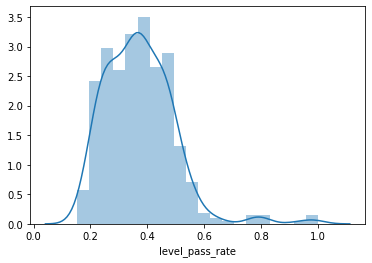

In [248]:
sns.distplot(dataset_1['level_pass_rate'], bins = 20)
plt.show()

### Нарисуем графики распределения количества выбывших игроков

Видим, что график напоминает смещенное нормальное распределение с коротким левым хвостом и длинным правым. Видим, что на некоторых уровнях до 200 количество выбывших игроков может достигать 1.2% , то есть много игроков после этих бросили игру. Проблема в том, что график ниже не дает понимания плотности распределения выбывших игроков по уровням.

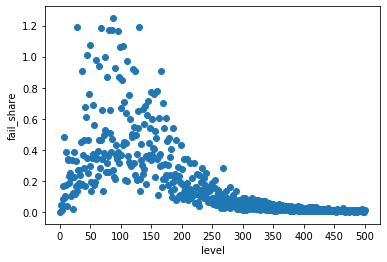

In [249]:
plt.scatter(x = dataset_2.index, y = dataset_2.fail_share)
plt.xticks(np.linspace(0, 500, 11))
plt.xlabel('level')
plt.ylabel('fail_share')
plt.show()

### Кумулятивный график для количества выбывших игроков по уровням

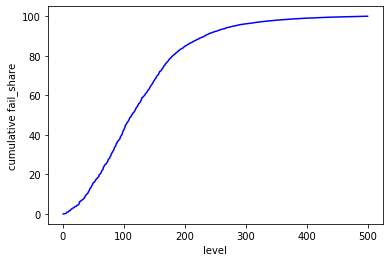

In [250]:
dataset_2 = dataset_2.sort_index()
cumulative_dataset_2 = np.cumsum(dataset_2[['fail_share']])

plt.plot(dataset_2.index, cumulative_dataset_2, c='blue')
plt.xlabel('level')
plt.ylabel('cumulative fail_share')
plt.show()

### Промежуточный вывод по графикам

Видно, что уровни примерно от 50 до 200 обладают наибольшим количеством неудачных попыток среди всех. Заметим, что количество неудачных попыток постепенно снижается, начиная примерно с 200 уровня и до самого последнего. Основная причина, количество пользователей, дошедших до данного уровня, вторая - вероятно, скилл дошедших до этого места игроков в среднем выше, чем у других игроков, но эту гипотезу следует проверить

## Разделение уровней по сложности

Разделить уровни по сложности можно как по проценту успешных / неуспешных попыток, так и по тому, насколько часто на определенном уровне игрок переставал играть, что выражено в показателе fail_rate.

In [251]:
def level_grader(dataset, col_name, bottom_outliers = None, top_outliers = None):
    
    if bottom_outliers is not None:
        
        dataset.loc[dataset[col_name] <= bottom_outliers, 'level_difficulty'] = "Слишком легкий"
        dataset.loc[(dataset[col_name].quantile(0.5) >= dataset[col_name]) & (dataset[col_name] > bottom_outliers), 'level_difficulty'] = "Легкий"
        dataset.loc[(dataset[col_name].quantile(0.75) >= dataset[col_name]) & (dataset[col_name] > dataset[col_name].quantile(0.5)), 'level_difficulty'] = "Средний"
        dataset.loc[dataset[col_name] > dataset[col_name].quantile(0.75), 'level_difficulty'] = "Сложный"
        
    if top_outliers is not None:
        
        dataset.loc[dataset[col_name].quantile(0.5) >= dataset[col_name], 'level_difficulty'] = "Легкий"
        dataset.loc[(dataset[col_name].quantile(0.75) >= dataset[col_name]) & (dataset[col_name] > dataset[col_name].quantile(0.5)), 'level_difficulty'] = "Средний"
        dataset.loc[(dataset[col_name] > dataset[col_name].quantile(0.75)) & (dataset[col_name] <= top_outliers), 'level_difficulty'] = "Сложный"
        dataset.loc[dataset[col_name] > top_outliers, 'level_difficulty'] = "Очень сложный"
    
    return dataset

### Разделение по уровням 1: Разделение по проценту успешных / неуспешных попыток

Из графика видим несколько выбросов с низким процентом "завалов", поэтому разделим данные на группы по следующему показателю level_fail_rate:
<br>
Слишком легкие : level_fail_rate <= bottom_outliers
<br>
Легкие : Медиана >= level_fail_rate > bottom_outliers
<br>
Средние :  0.75 квантиль >= level_fail_rate > Медиана
<br>
Сложные :  level_fail_rate > 0.75 квантиль 

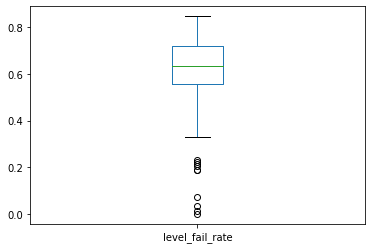

In [275]:
dataset_1.level_fail_rate.plot(kind = 'box')
plt.show()

In [253]:
dataset_1_outliers = dataset_1.level_fail_rate.quantile(0.25) - 1.5 * (dataset_1.level_fail_rate.quantile(0.75) - dataset_1.level_fail_rate.quantile(0.25))

In [254]:
dataset_1.columns = dataset_1.columns.add_categories(['level_difficulty'])

In [255]:
dataset_1 = level_grader(dataset_1, 'level_fail_rate', bottom_outliers = dataset_1_outliers)

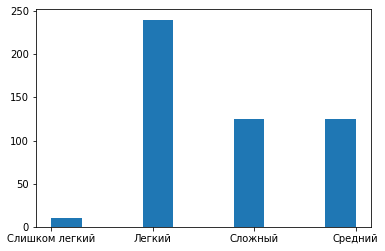

In [274]:
plt.hist(dataset_1.level_difficulty)
plt.show()

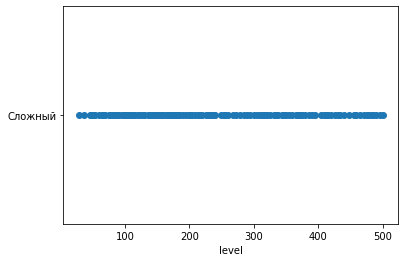

In [273]:
plt.scatter(x = list(dataset_1[dataset_1.level_difficulty == 'Сложный'].index), y = dataset_1.loc[dataset_1.level_difficulty == 'Сложный', 'level_difficulty'])
plt.xlabel('level')
plt.show()

In [258]:
print('Первое разделение по уровням сложности:')
print()
dataset_1.level_difficulty.value_counts()

Первое разделение по уровням сложности:



Легкий            240
Средний           125
Сложный           125
Слишком легкий     10
Name: level_difficulty, dtype: int64

### Вывод по разделению 1

Получилось, что распределение сложных уровней по игре довольно ровное. Таким образом, получается, что на протяжении всей игры уровни попроще перемежаются с уровнями посложнее. Мы не видим, например, распределения, где уровни до 100 очень простые, а потом все сложнее и сложнее, потому что в процессе игры отсеиваются слабые или немотивированные игроки и на уровне 47 процент неуспешных попыток может быть примерно таким же, как на уровне 499. 

### Разделение по уровням 2: по доле уровня в общем проценте провалов

Из графика видим несколько выбросов с низким процентом "завалов", поэтому разделим данные на группы по следующему показателю level_fail_rate:
<br>
Слишком легкие : fail_share <= top_outliers
<br>
Легкие : Медиана >= fail_share > top_outliers
<br>
Средние :  0.75 квантиль >= fail_share > Медиана
<br>
Сложные :  fail_share > 0.75 квантиль 

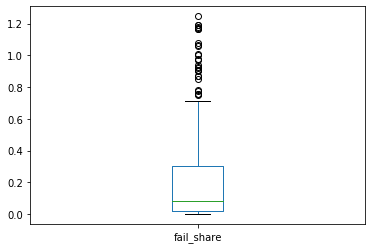

In [276]:
dataset_2.fail_share.plot(kind = 'box')
plt.show()

In [260]:
dataset_2_outliers = dataset_2.fail_share.quantile(0.75) + 1.5 * (dataset_2.fail_share.quantile(0.75) - dataset_2.fail_share.quantile(0.25))

In [261]:
dataset_2 = level_grader(dataset_2, 'fail_share', top_outliers = dataset_2_outliers)

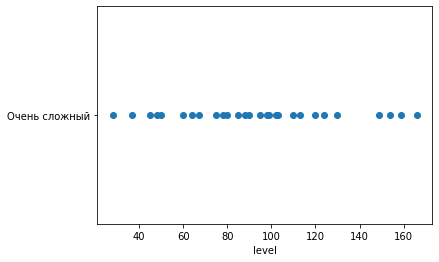

In [277]:
plt.scatter(x = list(dataset_2[dataset_2.level_difficulty == 'Очень сложный'].index), y = dataset_2.loc[dataset_2.level_difficulty == 'Очень сложный', 'level_difficulty'])
plt.xlabel('level')
plt.show()

In [263]:
print('Второе разделение по уровням сложности:')
print()
dataset_2.level_difficulty.value_counts()

Второе разделение по уровням сложности:



Легкий           250
Средний          125
Сложный           97
Очень сложный     28
Name: level_difficulty, dtype: int64

### Вывод по разделению 2

Видим, что разделение 2 сильно отличается от первого во всех отношениях. 
<br>
Здесь очень сложные уровни лежать в пределах до уровня 200 и распределены достаточно равномерно первым двум сотным уровней. Самый плотный участов - уровни 70 - 120, где лежит наибольшая часть самых сложных уровней, согласно данному разбиению.

## Разделение по уровням 3: 
## Дополнительный вариант разбиения (решил использовать его позже, когда составлял воронку)

In [264]:
dataset_3 = dataset_temp.reset_index()
dataset_3['passed_at_level'] = np.where(dataset_3.completed > 0, 1, 0)
dataset_3['failed_at_level'] = np.where(dataset_3.completed > 0, 0, 1)

dataset_3 = dataset_3.groupby('level').agg({'passed_at_level' : 'sum', 'failed_at_level' : 'sum'})
dataset_3['total_players'] = dataset_3['failed_at_level'] + dataset_3['passed_at_level']
dataset_3['prct_failed_players'] = (dataset_3['failed_at_level'] / dataset_3['total_players']) * 100

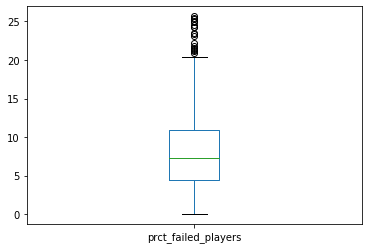

In [271]:
dataset_3.prct_failed_players.plot(kind = 'box')
plt.show()

In [266]:
dataset_3_outliers = dataset_3.prct_failed_players.quantile(0.75) + 1.5 * (dataset_3.prct_failed_players.quantile(0.75) - dataset_3.prct_failed_players.quantile(0.25))
dataset_3 = level_grader(dataset_3, 'prct_failed_players', top_outliers = dataset_3_outliers)

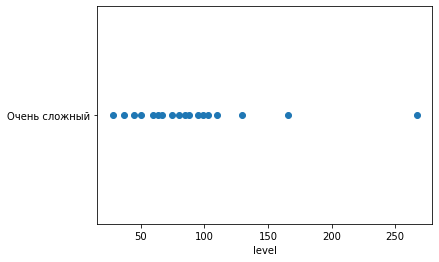

In [272]:
plt.scatter(x = list(dataset_3[dataset_3.level_difficulty == 'Очень сложный'].index), y = dataset_3.loc[dataset_3.level_difficulty == 'Очень сложный', 'level_difficulty'])
plt.xlabel('level')
plt.show()

In [268]:
print('Третье разделение по уровням сложности:')
print()
dataset_3.level_difficulty.value_counts()

Третье разделение по уровням сложности:



Легкий           250
Средний          125
Сложный          107
Очень сложный     18
Name: level_difficulty, dtype: int64

### Вывод по разделению 3

Видим, что разделение 3 отличается от разделения 2.
<br>
Здесь очень сложные уровни лежать в пределах до уровня 120 и распределены очень плотно в первой сотне уровней. Именно данное разбиение мне кажется самым адекватным и метрику prct_failed_players я выбираю как основную

## Вывод по заданию 2

Основная метрика - метрика prct_failed_players из dataset_3. 
<br>
Эта метрика подсчитывает сколько игроков провались на данном уровне от общего количества игроков(не попыток) на данном уровне. Благодаря этой метрике можно найти уровни, после которых игроки чаще всего заканчивают игру.

## Решение задачи 3

#### Рассчитать "воронку" прохождения уровней новым пользователем после установки игры.

Воронку представим в виде таблицы, которая была построена в процессе решения второй задачи: 
<br>
1)количество игроков, прошедших уровень
<br>
2)количество игроков, застрявших на уровне
<br>
3)процент застрявших от общего количества

In [269]:
dataset_3[['passed_at_level', 'failed_at_level', 'prct_failed_players']].head()

,passed_at_level,failed_at_level,prct_failed_players
level,,,
1,24157,5,0.020694
2,21987,190,0.856743
3,21232,183,0.854541
4,20864,52,0.248614
5,20296,329,1.595152


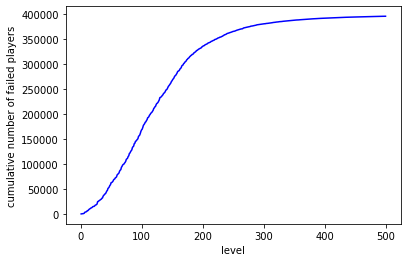

In [270]:
dataset_3 = dataset_3.sort_index()
cumulative_dataset_3 = np.cumsum(dataset_3[['failed_at_level']])

plt.plot(dataset_3.index, cumulative_dataset_3, c='blue')
plt.xlabel('level')
plt.ylabel('cumulative number of failed players')
plt.show()

### Вывод по задаче 3

Видим, что от первых уровней до уровня 180-190 количество выбывающих игроков примерно стабильно и образует почти прямую линию. Дальше отсекающихся игроков становится все меньше. 
<br>
Интересно было бы посмотреть сколько людей проходит игру после прохождения очень сложных уровней. Например, сравнить какой процент игроков проходит игру из тех, кто начинает и из тех, кто проходит уровень 200.